In [1]:
# author Chong Teng
# experimental pKa data from DataWarrior http://www.openmolecules.org/index.html

import os
import pandas as pd
import numpy as np
from Util import *
from periodictable import elements

In [2]:
#m=smile_to_mol("CCSC([C@H](C1)N(C)[C@@H]2CC1=O)[C@H]2O") #test
df = pd.read_csv(r"./pKaInWater.dwar",sep="	")

In [ ]:
# read file and convert to 3d-mol save to pkl.
df['m']=df['Smiles'].apply(smile_to_mol)
df.to_pickle("./temp.pkl")

In [75]:
df=pd.read_pickle("./temp.pkl")

In [77]:
df.dropna(subset=["pKa","Smiles"],inplace=True)               # drop invaild data
df['m_text']=df['m'].apply(mol_to_text)
df['coord']=df['m_text'].apply(get_coordinate)
df['cm']=df['coord'].apply(coulomb_matrix)
df.dropna(subset=["cm"],inplace=True)                         # drop invaild data


In [78]:
# normalize & resize coulomb_matrix 
df['cm_length']=df['cm'].apply(len)
df['cm_norm']=df['cm']/max_num(df['cm'])
len_max=df['cm_length'].max()
df['cm_resize']=df['cm_norm'].apply(lambda x: vec_resize(x,len_max))
df.dropna(inplace=True)

In [79]:
# map acid/base to 0/1
df['ab']=df['basicOrAcidic'].map({'acidic':0,'basic':1})

In [80]:
# convert obj to df for tf
x_train=[]
for i in df['cm_resize']:
    x_train.append(i)
dataset_all=pd.DataFrame(x_train)
dataset_all['ab']=df['ab']
dataset_all['pKa']=df['pKa']
dataset_all.dropna(inplace=True)

In [81]:
train_data=dataset_all.sample(frac=0.9,random_state=0)
test_data=dataset_all.drop(train_data.index)

train_labels=train_data.pop('pKa')

train_data=train_data.reset_index(drop=True)
train_labels=train_labels.reset_index(drop=True)

test_labels=test_data.pop(('pKa'))




In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [86]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
         ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [87]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                7616      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 11,841
Trainable params: 11,841
Non-trainable params: 0
_________________________________________________________________


In [88]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 100

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [89]:
import matplotlib.pyplot as plt
    

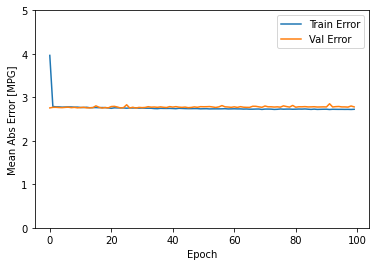

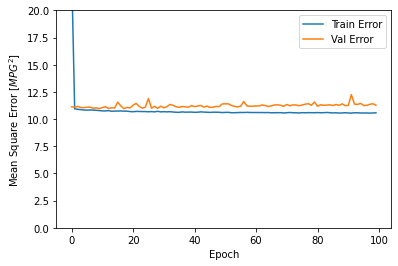

In [91]:
def plot_history(history):
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Mean Abs Error [MPG]')
      plt.plot(hist['epoch'], hist['mae'],
               label='Train Error')
      plt.plot(hist['epoch'], hist['val_mae'],
               label = 'Val Error')
      plt.ylim([0,5])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Mean Square Error [$MPG^2$]')
      plt.plot(hist['epoch'], hist['mse'],
               label='Train Error')
      plt.plot(hist['epoch'], hist['val_mse'],
               label = 'Val Error')
      plt.ylim([0,20])
      plt.legend()
      plt.show()


plot_history(history)